<a href="https://colab.research.google.com/github/nguepigit2020/Group3_Repository/blob/main/NLP_Tweets_Disaster_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> CountVectorizer vs Tfidf Vectorizer vs BERT </h1>

In this notebook, we are going to detail our approach to the Predicting Disaster Tweets NLP competition with all of the models and pipelines we tested. 

**Now, here are the models and pipelines combinations we are going to test:**


<li>Count Vectorizer + Logistic Regression
<li>Count Vectorizer + Naive Bayes
<li>Tfidf + Logistic Regression
<li>Tfidf + Naive Bayes
<li>BERT

    

---

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.6 MB/s 
     |████████████████████████████████| 6.6 MB 31.3 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


<h2> Importing Libraries, Functions and Datasets </h2>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_style('darkgrid')

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import feature_extraction
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')


from keras import Input
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from transformers import BertTokenizer, TFBertModel

In [ ]:
class Cross_valid:
    def __init__(self,train_data,n_splits):
        self.best_score = 0
        self.best_model = list()
        self.best_model_std = 0
        self.feature_cols = None
        
        train_data['kfold'] = -1

        kf = KFold(n_splits=n_splits,shuffle=True)
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_data)):
            train_data.loc[valid_idx,'kfold'] = fold
        
        self.data = train_data
        self.n_splits = n_splits
        
    
    def run_model(self, pipeline_steps, model, feature_cols, target_col, valid_pipeline = False):
        data = self.data.copy()
        current_model_scores = np.array([])
        print(f'Now running the {str(model)} model...\n')
        for fold in range(self.n_splits):
            x_train = data[data['kfold'] != fold][feature_cols].copy()
            x_valid = data[data['kfold'] == fold][feature_cols].copy()
            
            y_train = data[data['kfold'] != fold][target_col].copy()
            y_valid = data[data['kfold'] == fold][target_col].copy()
            
            x_train_pipelined = Pipeline(steps=pipeline_steps).fit_transform(x_train)
            x_valid_pipelined = Pipeline(steps=pipeline_steps).transform(x_valid)
                
            

            
            model.fit(x_train_pipelined,y_train)
            prediction_valid = model.predict(x_valid_pipelined)
            
            current_fold_score = f1_score(y_valid,prediction_valid)
            current_model_scores = np.append(current_model_scores,current_fold_score)
            
            print(f'Fold {fold} validation score: {current_fold_score}')
        
        
        avg_score = current_model_scores.mean()
        std = current_model_scores.std()
        print(f'Finished running {str(model)} model...\nAverage score: {round(avg_score,5)} \nStandard deviation: {round(std,5)}')
        
        if avg_score > self.best_score:
            self.best_score = avg_score
            self.best_model_std = std
            self.best_model = [pipeline_steps,model]
            self.feature_cols = feature_cols
            print(f'This is the new baseline model! New benchmark value of {round(self.best_score,5)}')
        else:
            print(f'This model failed to beat the benchmark score of {round(self.best_score,5)}...')

            
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    
class Reshaper(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X = X.to_numpy()
        n_size = X[0].shape[0]
        X = X.reshape(-1,1)
        X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, n_size)
        return X

    
def word_cloud(data,text_column,title=None):

    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in data[text_column]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1500, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image					
    plt.figure(figsize = (15, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 5)
    plt.suptitle(title,fontsize=25,fontweight=100)

    plt.show()
    
    
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

def f1(pred, y):
    score = f1_score(y,pred)
    return 'f1', score

class Text_clearer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X = X.apply(word_tokenize)
        return X
    

# Used the bert encoder and bert model. 

def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)





def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
test = pd.read_csv('/content/test.csv')
test.head(4)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires


In [ ]:
train = pd.read_csv('/content/train.csv')
train.head(4)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1


In [ ]:
sample_sub = pd.read_csv('/content/sample_submission.csv')
sample_sub.head(4)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0


<h2> Exploratory Data Analysis </h2>

In [ ]:
print('Null values by column on the train dataset:\n')
for column, null_pct in ((train.isna().sum())/(train.shape[0])).items():
    print(f'{round(null_pct*100,2)}% of values on the {column} column are null')

Null values by column on the train dataset:

0.0% of values on the id column are null
0.8% of values on the keyword column are null
33.27% of values on the location column are null
0.0% of values on the text column are null
0.0% of values on the target column are null


In [ ]:
print('Null values by column on the test dataset:\n')
for column, null_pct in ((test.isna().sum())/(test.shape[0])).items():
    print(f'{round(null_pct*100,2)}% of values on the {column} column are null')

Null values by column on the test dataset:

0.0% of values on the id column are null
0.8% of values on the keyword column are null
33.86% of values on the location column are null
0.0% of values on the text column are null


In [ ]:
print('Disaster tweets occurence of keywords:')
train[train['target'] == 1]['keyword'].value_counts()

Disaster tweets occurence of keywords:


derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: keyword, Length: 220, dtype: int64

In [ ]:
print('Non-disaster tweets occurence of keywords:')
train[train['target'] == 0]['keyword'].value_counts()

Non-disaster tweets occurence of keywords:


body%20bags          40
harm                 37
armageddon           37
wrecked              36
ruin                 36
                     ..
typhoon               1
suicide%20bombing     1
suicide%20bomber      1
outbreak              1
oil%20spill           1
Name: keyword, Length: 218, dtype: int64

Text(0.5, 0.98, 'Number of Tweets by Target')

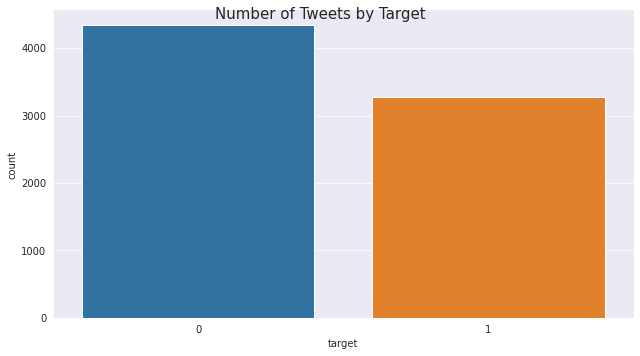

In [ ]:
sns.catplot(data=train,kind='count',x='target',aspect=1.8)
plt.suptitle('Number of Tweets by Target',fontsize=15,fontweight=100)

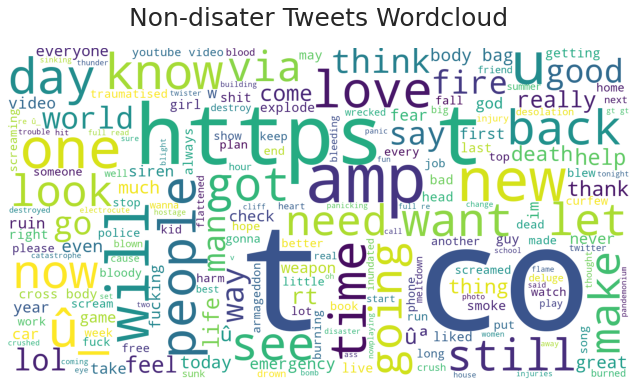

In [ ]:
word_cloud(train[train['target'] == 0],'text','Non-disater Tweets Wordcloud')

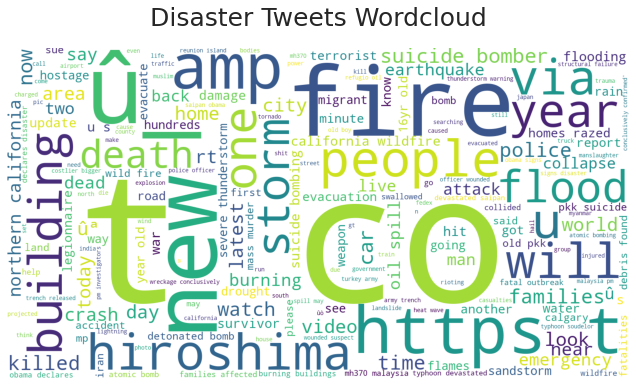

In [ ]:
word_cloud(train[train['target'] == 1],'text','Disaster Tweets Wordcloud')

<h2> Testing Models </h2>

<h3> Count Vectorizer + Logistic Regression </h3>

In [ ]:
cv_pipeline = [('cv',feature_extraction.text.CountVectorizer(stop_words='english',max_features=1000,ngram_range=(1,3))),
 ('todense',DenseTransformer())]

nb = GaussianNB()
lr = LogisticRegression()

print('Creating 5-fold cross-validation object...')
five_fold = Cross_valid(train,5)
five_fold.run_model(cv_pipeline,lr,feature_cols = 'text',target_col = 'target')

Creating 5-fold cross-validation object...
Now running the LogisticRegression() model...

Fold 0 validation score: 0.7186218211648893
Fold 1 validation score: 0.7272727272727272
Fold 2 validation score: 0.7187751813053989
Fold 3 validation score: 0.7491694352159469
Fold 4 validation score: 0.7364975450081832
Finished running LogisticRegression() model...
Average score: 0.73007 
Standard deviation: 0.0116
This is the new baseline model! New benchmark value of 0.73007


<h3> Count Vectorizer + Naive Bayes </h3>

In [ ]:
five_fold.run_model(cv_pipeline,nb,feature_cols = 'text',target_col = 'target')

Now running the GaussianNB() model...

Fold 0 validation score: 0.5150214592274678
Fold 1 validation score: 0.5063879210220674
Fold 2 validation score: 0.4767309875141885
Fold 3 validation score: 0.4770642201834862
Fold 4 validation score: 0.48654708520179374
Finished running GaussianNB() model...
Average score: 0.49235 
Standard deviation: 0.01564
This model failed to beat the benchmark score of 0.73007...


<h3> Tfidf + Logistic Regression </h3>

In [ ]:
tfidf_pipeline = [('cv',feature_extraction.text.TfidfVectorizer(stop_words='english',max_features=1000,ngram_range=(1,3))),
               ('todense',DenseTransformer())]


five_fold.run_model(tfidf_pipeline,lr,feature_cols = 'text',target_col = 'target')

Now running the LogisticRegression() model...

Fold 0 validation score: 0.7177814029363784
Fold 1 validation score: 0.7336170212765958
Fold 2 validation score: 0.7254740313272876
Fold 3 validation score: 0.7384868421052633
Fold 4 validation score: 0.7469287469287469
Finished running LogisticRegression() model...
Average score: 0.73246 
Standard deviation: 0.01011
This is the new baseline model! New benchmark value of 0.73246


<h3> Tfidf + Naive bayes </h3>

In [ ]:
five_fold.run_model(tfidf_pipeline,nb,feature_cols = 'text',target_col = 'target')

Now running the GaussianNB() model...

Fold 0 validation score: 0.4841875681570338
Fold 1 validation score: 0.49126891734575084
Fold 2 validation score: 0.4487917146144994
Fold 3 validation score: 0.4770642201834862
Fold 4 validation score: 0.45183486238532106
Finished running GaussianNB() model...
Average score: 0.47063 
Standard deviation: 0.01721
This model failed to beat the benchmark score of 0.73246...


<h3> BERT </h3>

We did not cross-validate the BERT model because it takes way too long to fit and predict and would probably give me 'out of memory' errors... But as you will be able to see shortly, it outperforms all of the other models.

In [ ]:
# BERT has dozens of pre-trained models, We took the smallest one in order to prevent out of memory errors.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_input_ids, train_attention_masks = bert_encode(train,60)
test_input_ids, test_attention_masks = bert_encode(test,60)

bert_model = TFBertModel.from_pretrained('bert-base-uncased',output_attentions=True)
model = create_model(bert_model)
history = model.fit([train_input_ids,train_attention_masks],train.target,validation_split=0.2, epochs=3,batch_size=50,workers=4,)
y_pred = model.predict([test_input_ids,test_attention_masks])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
113/122 [==========================>...] - ETA: 4:37 - loss: 0.5606 - accuracy: 0.7310

<h2> Final Model Training </h2>

And the winning pipeline for this problem was the BERT model, clearly outperforming all of the others.


In [ ]:
y_pred = np.round(y_pred).astype(int)
y_pred = pd.DataFrame(y_pred)
submission = pd.read_csv('/content/sample_submission.csv')
output = pd.DataFrame({'id':submission.id,'target':y_pred[0]})
output.to_csv('subm1.csv',index=False)
print('Done!')

Done!
